In [2]:
%load_ext cython

In [39]:
%%cython
cimport numpy as cnp
from libc.math cimport exp, fabs, sqrt

import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np

from cv2 import filter2D
from scipy.stats import norm
from pywt import idwt2, dwt2, threshold

from skimage.filters import threshold_otsu, median, _gaussian as gs
from skimage.color import rgb2gray, rgb2hsv, rgb2ycbcr, ycbcr2rgb, hsv2rgb, rgb2lab
from skimage.restoration import denoise_bilateral , estimate_sigma
#from skimage.metrics import structural_similarity, peak_signal_noise_ratio as psnr
from skimage.feature import greycomatrix, greycoprops
from skimage.util import random_noise
from skimage import img_as_float
from scipy.signal import convolve2d as conv

from timeit import default_timer as timer

ctypedef fused np_ints:
    cnp.int8_t
    cnp.int16_t
    cnp.int32_t
    cnp.int64_t

ctypedef fused np_uints:
    cnp.uint8_t
    cnp.uint16_t

ctypedef fused np_floats:
    cnp.float32_t
    cnp.float64_t

ctypedef fused np_double:
    double
    np_uints

ctypedef fused np_numeric:
    np_uints
    np_ints
    np_floats

cdef inline Py_ssize_t Py_ssize_t_min(Py_ssize_t value1, Py_ssize_t value2):
    if value1 < value2:
        return value1
    else:
        return value2

cdef inline np_numeric get_pixel3d(np_numeric* image,
                                        Py_ssize_t rows, Py_ssize_t cols,
                                        Py_ssize_t dims, Py_ssize_t r,
                                        Py_ssize_t c, Py_ssize_t d, char mode) nogil:

    return image[coord_map(rows, r, mode) * cols * dims +
                     coord_map(cols, c, mode) * dims +
                     coord_map(dims, d, mode)]

cdef inline Py_ssize_t coord_map(Py_ssize_t dim, long coord, char mode) nogil:
    cdef Py_ssize_t cmax = dim - 1
    if mode == b'E': # edge
        if coord < 0:
            return 0
        elif coord > cmax:
            return cmax
    return coord

def show_images(images,titles=None):
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()
    
class Image_Enhancement:    
    #Color_Balancing Constants
    RLB = 0.363 - 2 * 0.0723;
    RUB = 0.363 + 2 * 0.0723;
    GLB = 0.338 - 2 * 0.0097;
    GUB = 0.338 + 2 * 0.0097;
    BLB = 0.299 - 2 * 0.0749;
    BUB = 0.299 + 2 * 0.0749;
    
    def MinImage(self, np_double[:, :, ::1] img, np_double[:, :] minim):
        cdef:
            Py_ssize_t rows = img.shape[0]
            Py_ssize_t cols = img.shape[1]
            Py_ssize_t r, c
        
        for r in range(rows):
            for c in range(cols):
                minim[r, c] = min(img[r, c])
                
        min_avg = np.mean(minim)
        return min_avg

    def MaxImage(self, np_double[:, :, ::1] img, np_double[:, :] maxim):
        cdef:
            Py_ssize_t rows = img.shape[0]
            Py_ssize_t cols = img.shape[1]
            Py_ssize_t r, c
        
        for r in range(rows):
            for c in range(cols):
                maxim[r, c] = max(img[r, c])

        max_avg = np.mean(maxim)
        return max_avg

    def gaussian(self, array, sigma2, dtype=float):
        return 1.0 / np.sqrt((2 * np.pi * sigma2)) * np.exp(-0.5 * (array ** 2  / sigma2), dtype=dtype)

################################################################################################
    def Dehazing(self, img):
        image = np.copy(img)
        if(img.dtype != np.float):
            image = np.copy(img).astype(np.float)
            image = image / 255.0
            
        Minimum = np.zeros((image.shape[0],image.shape[1]))
        Maximum = np.zeros((image.shape[0],image.shape[1]))
        
        MinAVG = self.MinImage(image, Minimum) 
        MaxAVG = self.MaxImage(image, Maximum)
        
        contrastAVG = MaxAVG - MinAVG
        lamda = 1/3
        airlight = lamda * np.max(image) + (1 - lamda ) * MaxAVG;
        x1 = (airlight - MinAVG) / airlight;
        x2 = contrastAVG / airlight;
        hazeDegree = np.exp(-1/2 * (5.1* x1 + 2.9 * x2) + 0.2461);
        
        print("Haze ", hazeDegree)
       # if(hazeDegree < 0.45):
            #return image
        
        mask = np.ceil(max(image.shape[0], image.shape[1] * 3) / 50);  
        if (mask % 2 == 0):
            mask = mask + 1;  

        mask = np.int(mask)
        average_filter = (1/ (mask ** 2)) * np.ones((mask,mask))
        M_average = filter2D(Minimum, -1, average_filter)
        M_average_value = sum(sum(M_average)) / (M_average.shape[0] * M_average.shape[1]);
        delta = 2.0;    
        L1 = min( delta * M_average_value, 0.9)

        L = np.array(Minimum)
        for i in range(Minimum.shape[0]):
            for j in range(Minimum.shape[1]):
                L[i,j] = min(Minimum[i,j], L1 * M_average[i,j]) 

        Matrix = np.ones((3,1), dtype = np.uint16)

        A = 0.5 * ( np.max(image) + np.max(M_average) ) * Matrix;
        I_defog = np.zeros(image.shape , dtype = np.float64);
        
        for i in range(image.shape[2]):
            I_defog[:,:,i] = (image[:,:,i] - L) / (1 - (L / A[i]));
            
        I_defog[I_defog > 1] = 1
        I_defog[I_defog < 0] = 0
        return I_defog
    
################################################################################################
    def Estimate_Cast(self, img):
        if(img.dtype == np.float):
            image = np.copy(img).astype(np.double)
            image = image * 255
            image = image.astype(np.uint16)
        else:
            image = np.copy(img).astype(np.uint16)
            
        lab_image = rgb2lab(image[:,:,0:3])
        a = lab_image[:,:,1]
        b = lab_image[:,:,2]
        
        a_AVG = np.mean(a)
        b_AVG = np.mean(b)
        D = np.sqrt((a_AVG ** 2) + (b_AVG ** 2))

        M_a = np.mean(abs(a - a_AVG))
        M_b = np.mean(abs(b - b_AVG))
        
        M = np.sqrt((M_a ** 2) + (M_b ** 2))
        K = D/M
        
        return K
        
    def Color_Balancing(self, img):
        if(img.dtype == np.float):
            image = np.copy(img).astype(np.double)
            image = image * 255
            image = image.astype(np.uint16)
        else:
            image = np.copy(img).astype(np.uint16)

        img_lbr = np.round(image/ 4).astype(np.uint16)
        img_lbr[img_lbr == 64] = 63
        rgbh3d = np.zeros([64, 64, 64])

        rgbh3d[img_lbr[:,:,0],img_lbr[:,:,1],img_lbr[:,:,2]] = 1
        rgbh3d[0, :, :] = 0
        rgbh3d[:, 0, :] = 0
        rgbh3d[:, :, 0] = 0
        rgbh3d[62:63, :, :] = 0
        rgbh3d[:, 62:63, :] = 0
        rgbh3d[:, :, 62:63] = 0

        inds = np.where(rgbh3d == 1)
        rgb = ((np.array([inds[0],inds[1],inds[2]])[np.newaxis]).T)[:,:,0]

        t = np.array([[0.49 ,   0.31  ,  0.20],
                      [0.17697, 0.81240, 0.01063],
                      [0.00 ,   0.01 ,   0.99]])

        xyz = rgb.dot(t.T)
        xyz = xyz / np.tile(((np.sum(xyz, axis=1))[np.newaxis]).T,(1, 3)) 
        xy  = xyz.dot(np.array([[1, 0],
                                [0, 1],
                                [0, 0]]))

        A = np.array([[17.74, -10.17],
                     [-10.17, 22.06]])

        b = np.array([-2.86, -4.05])[np.newaxis].T


        Value1 = np.ones([1, xyz.shape[0]])
        Value2 = A.dot(xy.T) + b.dot(Value1)
        Value3 = np.power(Value2, 2)
        Value4 = np.sum(Value3, axis=0)
        Value5 = np.sqrt(Value4)
        Cands = Value5 <= 1

        white_cands = rgb;
        white_cands = white_cands[Cands == 1, :] 
        if len(white_cands) < 512:
            white_cands = rgb;

        lum = white_cands.dot(np.array([0,1,0]).T);
        l = (lum.T).dot(white_cands);
        l = l / np.sum(l);

        #Apply upper/lower bounds on illumination
        l[0] = l[0] * (l[0] <= self.RUB) + self.RUB * (l[0] > self.RUB);
        l[0] = l[0] * (l[0] >= self.RLB) + self.RLB * (l[0] < self.RLB);
        l[1] = l[1] * (l[1] <= self.GUB) + self.GUB * (l[1] > self.GUB);
        l[1] = l[1] * (l[1] >= self.GLB) + self.GLB * (l[1] < self.GLB);
        l[2] = l[2] * (l[2] <= self.BUB) + self.BUB * (l[2] > self.BUB);
        l[2] = l[2] * (l[2] >= self.BLB) + self.BLB * (l[2] < self.BLB);
        l = l/sum(l);

        #Apply white balance gains
        wb_gains = np.max(l) / l

        img_out = np.array(image)
        img_out[:, :, 0] = np.round(img_out[:, :, 0] * wb_gains[0]);
        img_out[:, :, 1] = np.round(img_out[:, :, 1] * wb_gains[1]);
        img_out[:, :, 2] = np.round(img_out[:, :, 2] * wb_gains[2]);

        img_out[img_out > 255] = 255
        illum = l
        img_out = img_out.astype(np.uint16)
        
        return img_out

################################################################################################    
    def Sharpening(self,img):
        Filter = np.array( [[-1, -1 ,-1 ,-1 ,-1],
                            [-1, 2  ,2  ,2  ,-1],
                            [-1, 2  ,8  ,2  ,-1],
                            [-1, 2  ,2  ,2  ,-1],
                            [-1, -1 ,-1 ,-1 ,-1]]) /8.0

        sharpen_image = filter2D(img, -1, Filter)
        sharpen_image[sharpen_image < 0] = 0
        if(sharpen_image.dtype == np.float):
            sharpen_image[sharpen_image > 1] = 1
        else:
            sharpen_image[sharpen_image > 255] = 255
        return sharpen_image

################################################################################################    
    def NonZeroMin(self, img):
        image = np.copy(img)
        vectorImage = image.flatten()
        vectorImage = np.sort(vectorImage)
        vectorImage = np.unique(vectorImage)
        if(len(vectorImage) == 1):
            return vectorImage[0]
        
        if vectorImage[0] != 0:
            return vectorImage[0]

        return vectorImage[1]

################################################################################################    
    def Get_Contrast(self, img):
        Gray_Scale_Img = rgb2gray(img)
        Gray_Scale_Img = Gray_Scale_Img * 255
        Gray_Scale_Img = Gray_Scale_Img.astype('uint8')
        Co_ocurance_Matrix = greycomatrix(Gray_Scale_Img, distances=[4], angles=[np.pi/4])
        Contrast = greycoprops(Co_ocurance_Matrix, prop='contrast')

        return Contrast[0,0]
    def Get_Homogeneity(self, img):
        Gray_Scale_Img = rgb2gray(img)
        Gray_Scale_Img = Gray_Scale_Img * 255
        Gray_Scale_Img = Gray_Scale_Img.astype('uint8')
        Co_ocurance_Matrix = greycomatrix(Gray_Scale_Img, distances=[4], angles=[np.pi/4])
        Contrast = greycoprops(Co_ocurance_Matrix, prop='homogeneity')

        return Contrast[0,0]

################################################################################################
    def Check_Brightness(self, img):
        
        if (img.dtype == np.float):
            image = np.copy(img).astype(np.double)
            image = 255 * image
            image = image.astype(np.uint16)        
        else:
            image = np.copy(img).astype(np.uint16)


        vec = np.zeros(256)
        for i in range (256):
            vec[i] = len(image[image == i])/(image.shape[0] * image.shape[1])   #frequencies.

        vec = vec * 255
        vec = np.rint(vec)

        low = (sum(vec[0:50]))
        high = (sum(vec[80:256]))
        answer = (low * 100/ (low + high))
        print("Brightness ", answer)
        if answer > 85:
            return True
        return False

    def Low_Light_Enhancement(self, img):
        if(img.dtype == np.float):
            image = np.copy(img).astype(np.double)
            image = image * 255
            image = image.astype(np.uint16)
        else:
            image = np.copy(img).astype(np.uint16)
            
        # (1) Find First Min Non Zero Pixel
        image[:,:,0] += self.NonZeroMin(image[:,:,0])
        image[:,:,1] += self.NonZeroMin(image[:,:,1])
        image[:,:,2] += self.NonZeroMin(image[:,:,2])

        # (2) Normalize The Image because from previous step will be pixel value >255
        image = image.astype(np.double)
        image[:,:,0]  = image[:,:,0]/ image[:,:,0].max()
        image[:,:,1]  = image[:,:,1]/ image[:,:,1].max()
        image[:,:,2]  = image[:,:,2]/ image[:,:,2].max()
        image = image * 255
        image = np.round(image)
        image = image.astype(np.uint16)

        # (3)  maximum luminance regardless of the channels
        maxImage =  np.zeros(image.shape[0:2]).astype('uint16')
        self.MaxImage(image, maxImage)

        # (4) Solve Non Linear Proplem 
        maxImage=(maxImage - maxImage.min())/(maxImage.max() - maxImage.min())

        # (5) Gamma Correction 
        maxImage = maxImage ** 0.47

        # Last Step to Replace the Value Channel of the HSV Image 
        hsvImage = rgb2hsv(image)
        prevousS = hsvImage[:,:,1]
        hsvImage[:,:,2] = maxImage
        result = hsv2rgb(hsvImage)

        # nextHSV=rgb2hsv(printImage)
        # nextS=nextHSV[:,:,1]
        # nextHSV[:,:,1]=prevousS+nextS
        # iast=nextHSV[:,:,1]
        # for i in range (iast.shape[0]):
        #     for j in range (iast.shape[1]):
        #         if iast[i,j] > 1 :
        #             iast[i,j]-=1
        # nextHSV[:,:,1]=iast
        # print(iast.max())
        #lastimage=hsv2rgb(nextHSV)


        result = result * 255
        result = result.astype(np.uint16)
        
        return result
################################################################################################
    #Different Thresholding Techniques
    def bayes_thresh(self, details, var):
        """BayesShrink threshold best results"""
        dvar = np.mean(details*details)
        eps = np.finfo(details.dtype).eps
        thresh = var / np.sqrt(max(dvar - var, eps))
        return thresh

    def optimal_thresh(self, subband):
        noise = np.median(abs(subband))/0.6745
        g = np.sum( np.square(subband) ) / subband.shape[0] / subband.shape[1]
        thresh = (noise * 2) / np.sqrt(max(0 ,( g * 2) - (noise ** 2) ))
        return thresh

    def universal_thresh(self, img, sigma):
        "blurs the image"
        return sigma*np.sqrt(2*np.log(img.size))


    def sigma_est_dwt(self, detail_coeffs, distribution='Gaussian'):
        detail_coeffs = detail_coeffs[np.nonzero(detail_coeffs)]
        denom = norm.ppf(0.75)
        sigma = np.median(np.abs(detail_coeffs)) / denom
        return sigma

    def soft_thresh(self, subband , thresh):
        subband2 = (abs(subband) - thresh) * np.sign(subband) 
        subband[abs(subband) > thresh] = subband2[(subband)]
    
    def Estimate_noise(self, img):
        if(img.max() < 2):
            img = img * 255
            img = img.astype(np.uint8)
        H, W = img.shape
        M = [[1, -2, 1],
             [-2, 4, -2],
             [1, -2, 1]]

        sigma = np.sum(np.sum(np.absolute(conv(img, M))))
        sigma = sigma * np.sqrt(0.5 * np.pi) / (6 * (W-2) * (H-2))
        return sigma
################################################################################################
    def bilat_utility(self, np_floats[:, :, ::1] image, double max_value,
                           Py_ssize_t window_size, double sig_color,
                           double sig_spatial, np_floats[::1] color_filter,
                           np_floats[::1] gauss_filter, np_floats[::1] empty_dims,
                           np_floats[:, :, ::1] out):
        cdef:
            Py_ssize_t rows = image.shape[0]
            Py_ssize_t cols = image.shape[1]
            Py_ssize_t dims = image.shape[2]
            Py_ssize_t radius = (window_size - 1) // 2
            Py_ssize_t max_color_filter_bin = 49999
            char cmode = ord('E')

            Py_ssize_t r, c, d, wr, wc, kr, kc, rr, cc, pixel_addr, color_filter_bin
            np_floats value, weight, dist, total_weight, csigma_color, color_weight, range_weight, t
            np_floats dist_scale
            np_floats[:] values
            np_floats[:] centres
            np_floats[:] total_values

        dist_scale = (50000 / dims) / max_value
        values = empty_dims.copy()
        centres = empty_dims.copy()
        total_values = empty_dims.copy()

        for r in range(rows):
            for c in range(cols):
                total_weight = 0

                for d in range(dims):
                    total_values[d] = 0
                    centres[d] = image[r, c, d]

                for wr in range(-radius, radius + 1):
                    rr = wr + r
                    kr = wr + radius

                    for wc in range(-radius, radius + 1):
                        cc = wc + c
                        kc = wc + radius

                        # Save pixel values for all dims and compute euclidean
                        # distance between centre stack and current position
                        dist = 0
                        for d in range(dims):
                            value = get_pixel3d(&image[0, 0, 0], rows, cols, dims, rr, cc, d, cmode)
                            values[d] = value
                            t = centres[d] - value
                            dist += t * t
                        dist = sqrt(dist)

                        range_weight = gauss_filter[kr * window_size + kc]

                        color_filter_bin = Py_ssize_t_min(<Py_ssize_t>(dist * dist_scale), max_color_filter_bin)
                        color_weight = color_filter[color_filter_bin]

                        weight = range_weight * color_weight
                        for d in range(dims):
                            total_values[d] += values[d] * weight
                        total_weight += weight
                for d in range(dims):
                    out[r, c, d] = total_values[d] / total_weight

        return np.squeeze(np.asarray(out))

    def bilateral_filter(self, image, window_size=None, sig_color=None, sig_spatial=1):

        max_value = image.max()
        radius = window_size // 2

        # If the image is grayscale make the 3rd dimension 1.
        image = np.atleast_3d(img_as_float(image))

        # makes image in a contiguous order in memory to increase speed of calculations.
        image = np.ascontiguousarray(image)

        # initialize it by the standard deviation of the image pixel values.
        if (sig_color == None):
            sig_color = image.std()

        # Computing color difference filter.
        values = np.linspace(0, max_value, 50000, endpoint=False)
        color_filter = self.gaussian(values, sig_color**2, image.dtype)

        # Computing gaussian filter
        array = np.arange(-radius, radius + 1)
        rows_mat, cols_mat = np.meshgrid(array, array, indexing='ij')
        distances = np.hypot(rows_mat, cols_mat)
        gauss_filter = self.gaussian(distances, sig_spatial).ravel()

        # Output image.
        out = np.empty(image.shape, dtype=image.dtype)

        # As we use multiple matrices in the utility function of dimension's size, initializing one here 
        # then copy it there will make it faster.
        dims = image.shape[2]
        empty_dims = np.empty(dims, dtype=image.dtype)

        return self.bilat_utility(image, max_value, window_size, sig_color,
                                  sig_spatial, color_filter,
                                  gauss_filter, empty_dims, out)

    def private_denoise(self, img):
    # Wavelet transform
        coeffs = dwt2(img, 'bior4.4')
        LL , (LH, HL, HH) = coeffs

        # 2nd level of wavelet transform
        coeffs2 = dwt2(LL , 'bior4.4')
        LL2 , (LH2, HL2, HH2) = coeffs2

        # threshold wavelet coeffs
        subbands = [LH , HL , HH , LH2 , HL2 , HH2 ]
        for i in range(0 , len( subbands )) :
            sigma = self.sigma_est_dwt(subbands[i])
            value = self.optimal_thresh(subbands[i])
            subbands[i] = threshold(subbands[i], 0.04  , mode ="soft")

        [LH , HL , HH , LH2 ,HL2 , HH2 ] = subbands   

        # Inverse wavelet for second level
        coeffs2 =   (LL2 ,(LH2 , HL2 , HH2))
        LL = idwt2(coeffs2 , 'bior4.4')
        if(LL.shape != HL.shape):
            LL = LL[:HL.shape[0] , :HL.shape[1]]

        #Inverse wavelet for first level
        coeffs =  (LL ,(LH , HL , HH))
        denoised = idwt2(coeffs , 'bior4.4')
        if(denoised.shape != img.shape):
            denoised = denoised[:img.shape[0] , :img.shape[1]]

        denoised = abs(denoised)
        return denoised

################################################################################################
    def Denoise(self, img , noise = 0.0):
        if(img.dtype == np.float):
            image = np.copy(img).astype(np.double)
            image = image * 255
            image = image.astype(np.uint8)
        else:
            image = np.copy(img).astype(np.uint8)
            
        start = timer() 
        image = np.copy(image)
        noisy = random_noise(image , var = noise)
        #noisy = random_noise(original , mode='s&p')

        if(image.ndim == 2 ):
            result = self.private_denoise(noisy)
        else:
            result = np.zeros(image.shape)
            result[:,:,0] = self.private_denoise(img= noisy[:,:,0])
            result[:,:,1] = self.private_denoise(img= noisy[:,:,1])
            result[:,:,2] = self.private_denoise(img= noisy[:,:,2])
            
            #bilateral filter
            result =  self.bilateral_filter(result , 3, sig_spatial = 7 , sig_color = 10)
            result[result < 0] = 0
            result [result > 1] = 1
            result =  self.bilateral_filter(result , 3, sig_spatial = 7 , sig_color = 10)

        #if(noise):
        #   print("psnr = " , psnr(image , (result*255).astype('uint8')))
            
        #print("Time taken = " , np.round(timer() - start, 2) , "secs")
        return result

################################################################################################
    def Enhance_Overall(self, Img):
        if(len(Img.shape) > 2):
            if(Img.shape[2] == 4):
                Img = Img[:,:,0:3]
                  
        #show_images([Img], ["Original"])
       
        print("Noise ", self.Estimate_noise(rgb2gray(Img) * 255))
        while(self.Estimate_noise(rgb2gray(Img) * 255) > 0.8):
            Img = self.Denoise(Img, 0)   
            #show_images([Img], ["Denoised"])   
        
    
        #show_images([Img], ["Dehazed"])   
        
        print("Cast ", self.Estimate_Cast(Img))
        if(self.Estimate_Cast(Img) > 1.3):
            Img = self.Color_Balancing(Img)
            #show_images([Img], ["Color_Balanced"])   
        
        if(self.Check_Brightness(Img)):
            Img = self.Low_Light_Enhancement(Img)
            #show_images([Img], ["Low_Ligh_Enhanced"])
        else:
            Img = self.Sharpening(Img)
        Img = self.Dehazing(Img)    
        #show_images([Img], ["Sharpening"])

        print("Noise ", self.Estimate_noise(rgb2gray(Img) * 255))
        while(self.Estimate_noise(rgb2gray(Img) * 255) > 2):
            Img = self.Denoise(Img, 0)   
            print("Noise ", self.Estimate_noise(rgb2gray(Img) * 255))
            #show_images([Img], ["Denoised"])   #Parameters Specified

        #Img = self.Sharpening(Img)
        
        if(Img.dtype == np.float):
            Img = Img.astype(np.double)
            Img = Img * 255
            Img = Img.astype(np.uint8)
        else:
            Img = Img.astype(np.uint8)
            
        return Img

Noise  1.0786850262182277
Haze  0.06655300393331362
Cast  1.2865873681530848
Brightness  22.6878612716763
Noise  0.0903549805403569


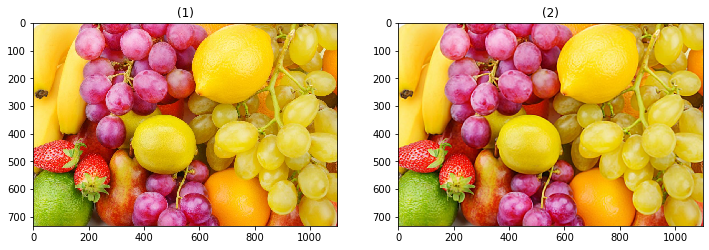

In [23]:
input_image = "Images/Fruit.jpg"
output_image = "result.jpg"
Image = io.imread(input_image)
Enhance = Image_Enhancement()
enhanced = Enhance.Enhance_Overall(Image)
show_images([Image, enhanced])
io.imsave(output_image , enhanced)

Noise  0.9451881437250532
Cast  1.3642641560638171
Brightness  98.0
Haze  0.40796726528445226
Noise  1.6485038319820633


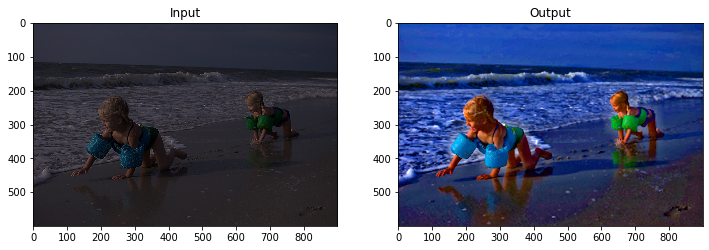

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Noise  0.7826761439854552
Cast  1.3417091574002291
Brightness  99.29971988795518
Haze  0.2578439636330686
Noise  3.459938207068948
Noise  0.038813256657647434


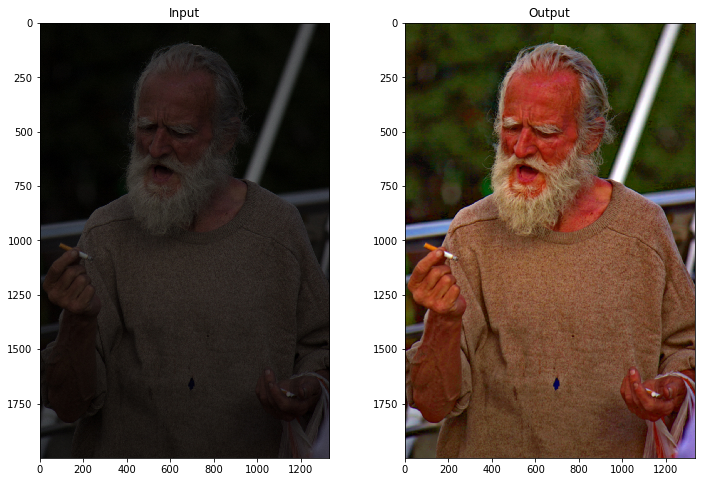

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Noise  0.18296980523965334
Cast  0.07765121752164714
Brightness  97.49262536873157
Haze  0.2790755035117449
Noise  0.6928673727151308


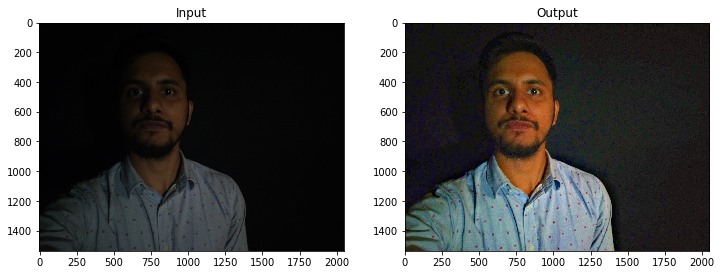

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Noise  0.779642749727815
Cast  0.7166810306365894
Brightness  98.44192634560906
Haze  0.170079294753359
Noise  1.6011909455254087


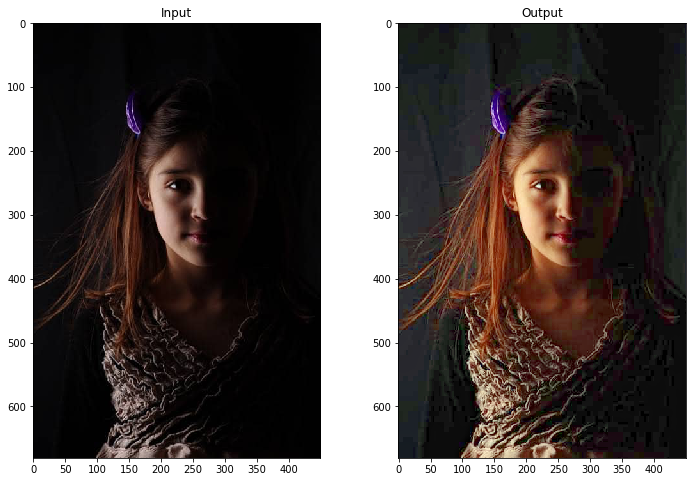

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Noise  0.4814947509937211
Cast  0.6512329795179115
Brightness  94.69153515064562
Haze  0.1074114233494181
Noise  0.8233487644232744


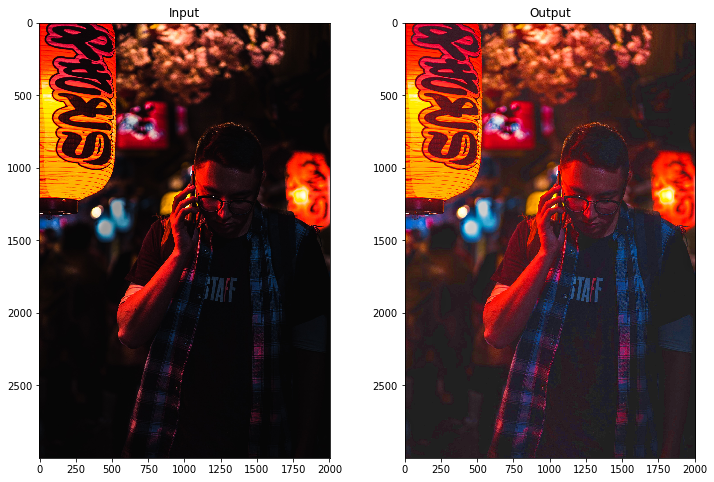

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Noise  0.742699141182322
Cast  1.9799888646499617
Brightness  100.0
Haze  0.19571051061930658
Noise  4.540317736153918
Noise  0.08475960609975706


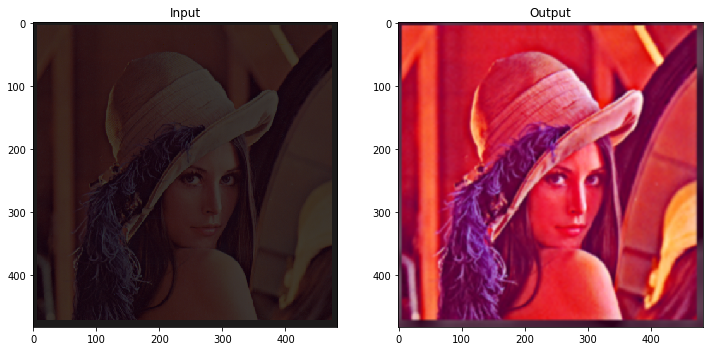

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Noise  0.45696408470914346
Cast  0.7194308803348682
Brightness  100.0
Haze  0.11714703738434504
Noise  3.8484381610954452
Noise  0.044456092335326026


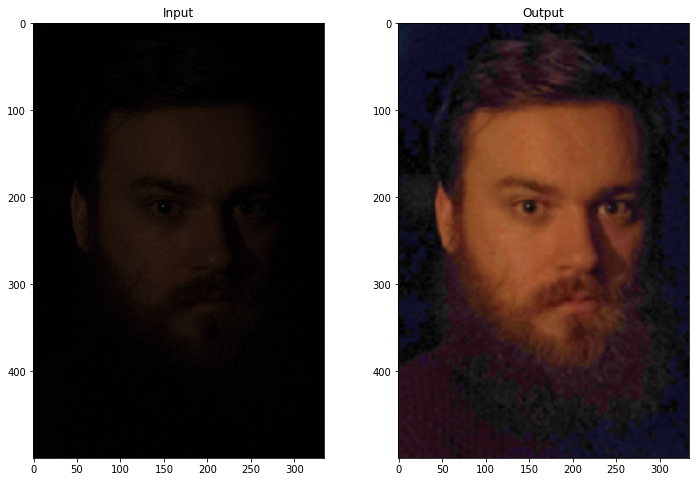

Lossy conversion from float64 to uint8. Range [0.0, 178.0]. Convert image to uint8 prior to saving to suppress this warning.


Noise  0.34507865158356993
Cast  0.5698174099033226
Brightness  100.0
Haze  0.11106030776547685
Noise  0.7461586146068612


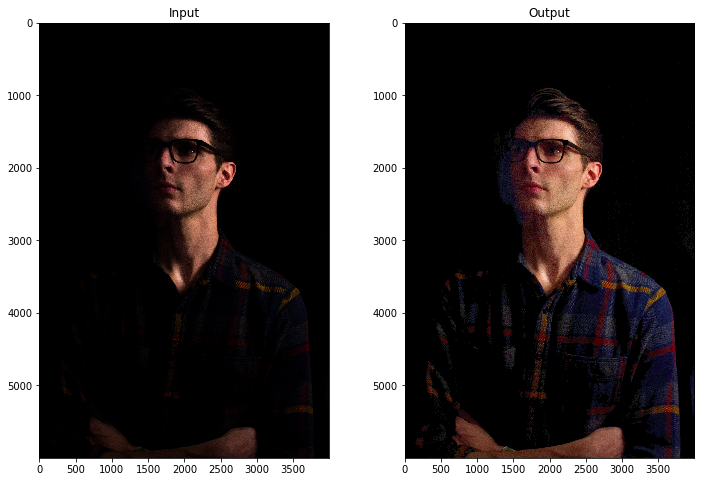

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


In [42]:
import os
fnames = os.listdir("Test Images/Low Light/")
Enhance = Image_Enhancement()
f= open("Test Images/Low Light/Info.txt","w")
for fn in fnames:
        path = os.path.join("Test Images/Low Light", fn)
        image=io.imread(path)
        f.write(str(image.shape)+"\n")
        start = timer()
        enhanced = Enhance.Enhance_Overall(image)
        f.write("Time taken = " + str(np.round(timer() - start, 2))+ " secs \n\n")
        show_images([image, enhanced],["Input","Output"])
        io.imsave("Test Images/Low Light Output individual/output_ "+fn,enhanced)
        merge=np.ones([image.shape[0],2*image.shape[1],image.shape[2]])
        merge[:,0:image.shape[1],:]=image
        merge[:,image.shape[1]:merge.shape[1],0:3]=enhanced
        if image.shape[2]==4:
            merge[:,image.shape[1]:merge.shape[1],3]=image[:,:,3]
        io.imsave("Test Images/Low Light Grouped//input_output_"+fn,merge)
f.close()


In [41]:
image=io.imread("Images/Low.jpg")

f.write("Test\n")
f.write("Test")

f.close()

Noise  0.3492689717312224
Haze  0.4019541341930595
Cast  0.8196746747955498
Brightness  10.56910569105691
Noise  0.36721441822094475


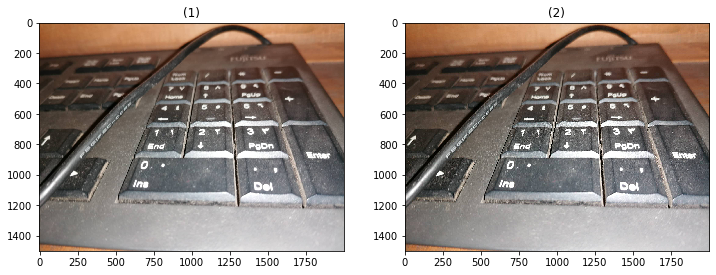

In [34]:
input_image = "Images/a.jpg"
output_image = "result.jpg"
Image = io.imread(input_image)

#noisy = random_noise(Image, var = 0.05)
Enhance = Image_Enhancement()
enhanced = Enhance.Enhance_Overall(Image)
show_images([Image, enhanced])
io.imsave(output_image , Image)
io.imsave('heh' + output_image, enhanced)

In [ ]:
io.imshow(enhanced)